In [1]:
# imports
import numpy as np
from scipy import io
import pyrsa

In [2]:
# loading RDMs for different layers of Alexnet and different measurement models
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][2][0] for i in range(n_models)])
model_rdms = pyrsa.rdm.RDMs(rdms_array,
                            rdm_descriptors={'model':model_names,
                                             'measurement':measurement_model}
                           )

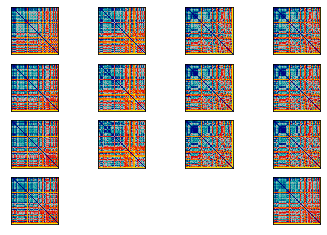

In [3]:
# as an example show the rdms from layer conv1
conv1_rdms = model_rdms.subset('model','conv1')
pyrsa.vis.show_rdm(conv1_rdms, do_rank_transform=True)

In [18]:
# loading simulated data
matlab_data = io.matlab.loadmat('rdms_inferring/noisyModelRDMs_demo.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')


In [19]:
rdms_matrix.shape

(4186, 9, 4, 3, 4)

The chosen ground truth model is:
conv2
with noise level:
3.0
with averaging width (full width at half magnitude):
16.0


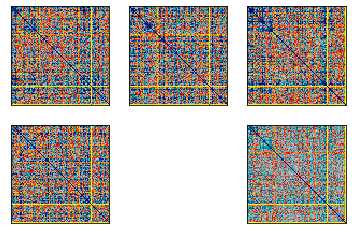

In [20]:
# randomly choosing ground truth
i_rep = np.random.randint(len(repr_names))
i_noise = np.random.randint(len(noise_std))
i_fwhm = np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into a RDMs object and show it
rdms_data = pyrsa.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())
pyrsa.vis.show_rdm(rdms_data, do_rank_transform=True)


In [21]:
# define (fixed) models:
models = []
for i_model in np.unique(model_names):
    models.append(pyrsa.model.ModelFixed(i_model,
        model_rdms.subset('model', i_model).subset('measurement','complete')))

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
norm1
norm2
pool1
pool2
prob


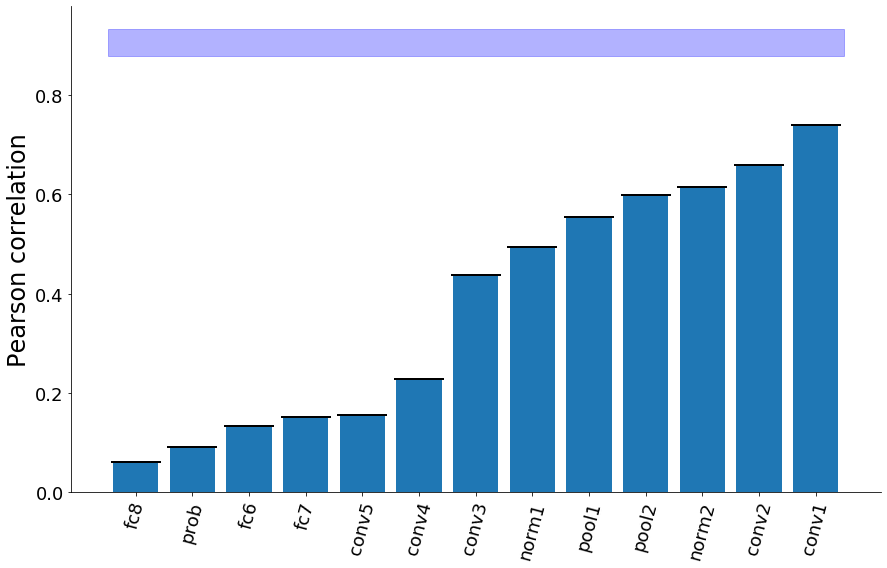

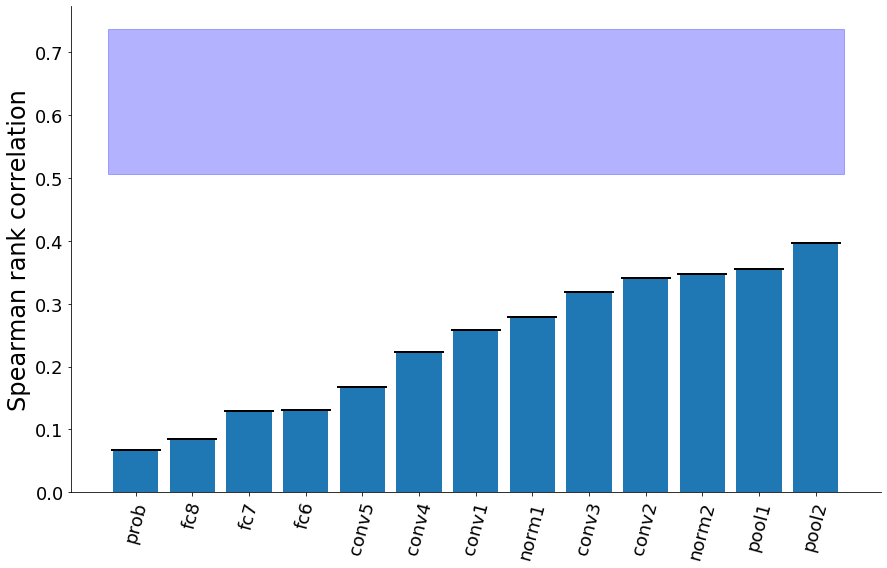

In [22]:
# RSA 1.0 just comparing RDMs to the measured RDMs

# evaluate models naively, i.e. simply compute the average correlation to the simulated data
results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_1)

results_1 = pyrsa.inference.eval_fixed(models, rdms_data, method='spearman')
pyrsa.vis.plot_model_comparison(results_1)

# In these plots the models do not have errorbars as we did not run any bootstrapping
# The upper noise ceiling is computed by evaluating the average of all rdms, which is 
# a true upper limit on performance
# The lower noise ceiling is a leave one out crossvalidation of the average, i.e. 
# all but one rdm are averaged and evaluated on the left out rdm.

# Make two additional observations here:
# 1) The true model is not necessarily winning as the different measurement models yield substantially different RDMs
# 2) Often none of the models reaches the noise ceiling
# Thus, to make this a sensible analysis one should take the measurement model into account!
# (See Kriegeskorte & Diedrichsen 2016)

100%|██████████| 1000/1000 [00:23<00:00, 42.75it/s]


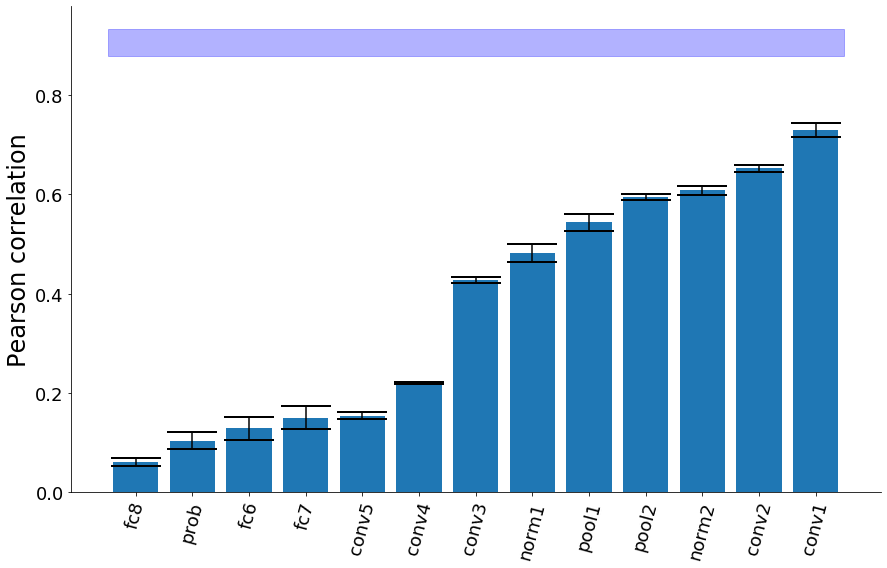

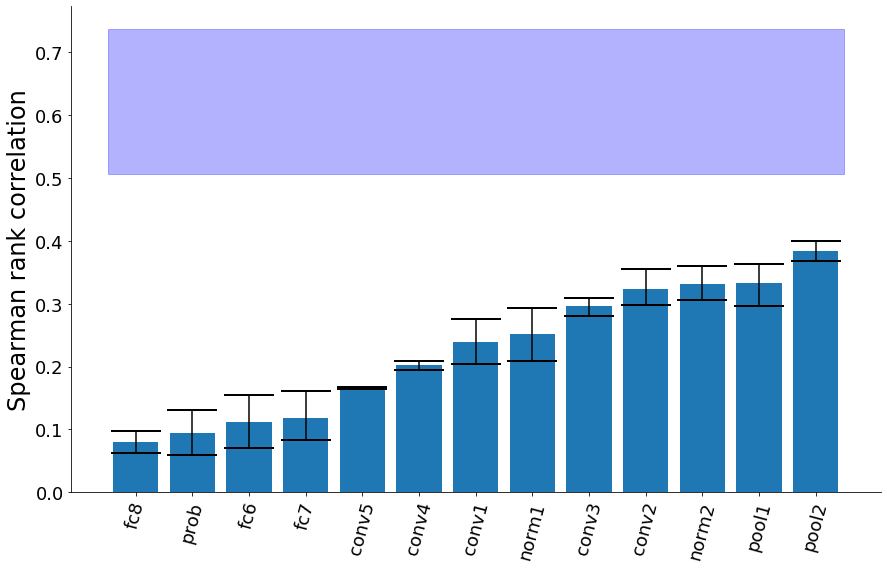

In [23]:
# RSA 2.0 bootstrapping -> Inference for fixed models with errorbars

# performing the same analysis as in RSA 1.0 with bootstrapping based errobars.
# a) using only bootstrapping over subjects
results_2a = pyrsa.inference.eval_bootstrap_rdm(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2a)

results_2a_spearman = pyrsa.inference.eval_bootstrap_rdm(models, rdms_data, method='spearman')
pyrsa.vis.plot_model_comparison(results_2a_spearman)


100%|██████████| 1000/1000 [00:29<00:00, 34.16it/s]


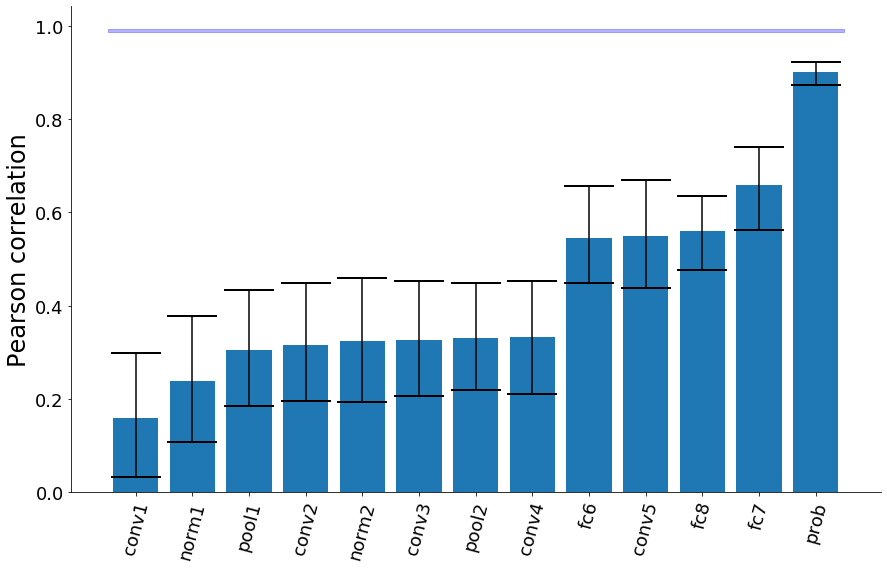

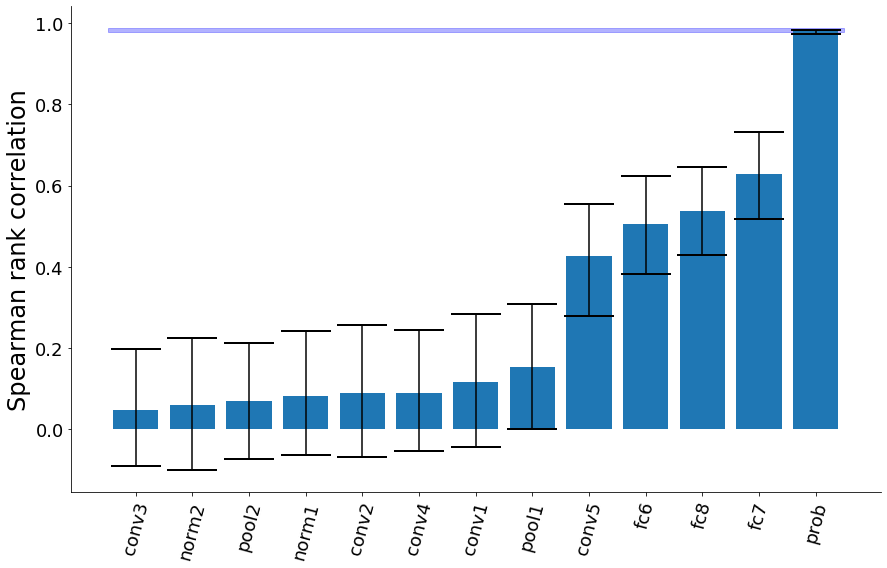

In [9]:
# b) using only bootstrapping over patterns
results_2b = pyrsa.inference.eval_bootstrap_pattern(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2b)

results_2b_spearman = pyrsa.inference.eval_bootstrap_pattern(models, rdms_data, method='spearman')
pyrsa.vis.plot_model_comparison(results_2b_spearman)

100%|██████████| 1000/1000 [00:29<00:00, 34.46it/s]


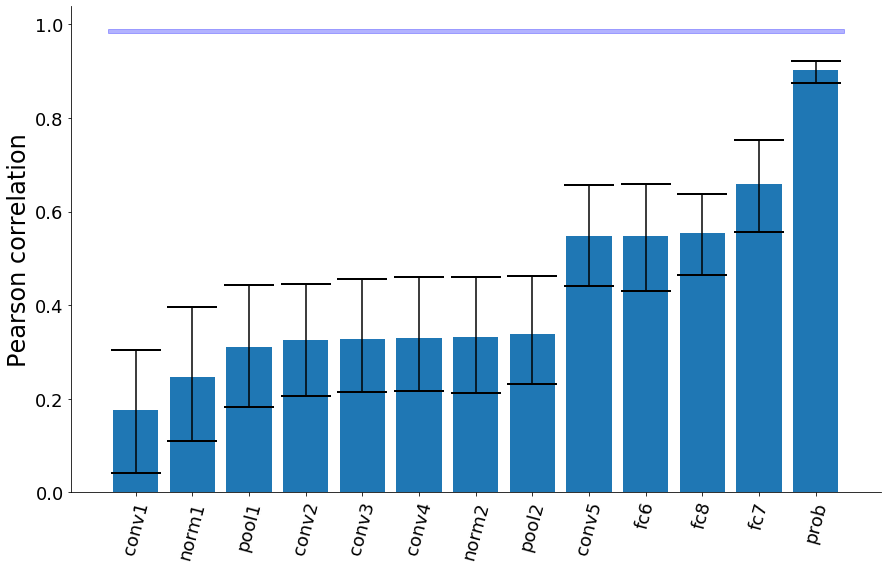

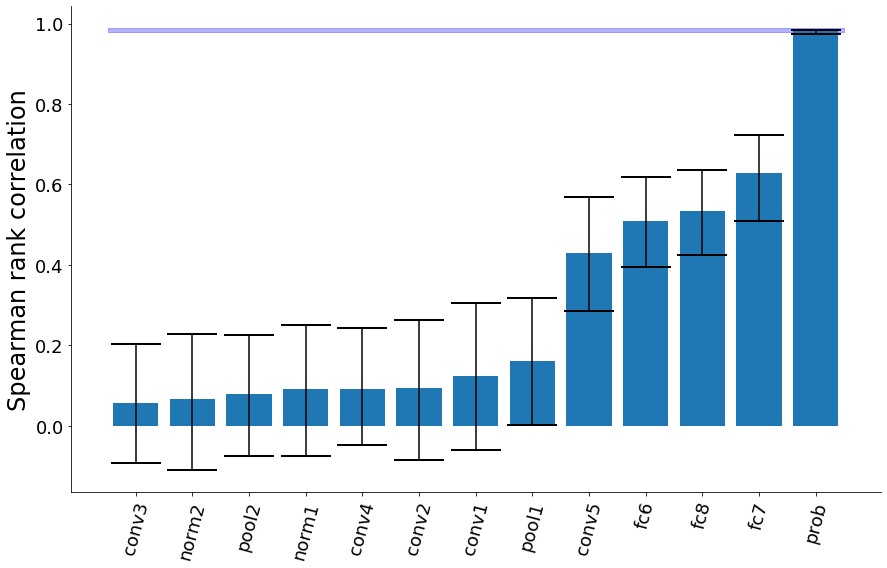

In [10]:
# c) bootstrap over both patterns and subjects
results_2c = pyrsa.inference.eval_bootstrap(models, rdms_data, method='corr')
pyrsa.vis.plot_model_comparison(results_2c)

results_2c_spearman = pyrsa.inference.eval_bootstrap(models, rdms_data, method='spearman')
pyrsa.vis.plot_model_comparison(results_2c_spearman)

In [11]:
# RSA 3.0 bootstrapped cross-validation, allows flexible models

# defining flexible models, here selection models, i.e. each model layer gets a list of rdms to choose from

models_flex = []
for i_model in np.unique(model_names):
    models_flex.append(pyrsa.model.ModelSelect(i_model,
        model_rdms.subset('model', i_model)))

print('created the following models:')
for i in range(len(models_flex)):
    print(models_flex[i].name)



created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
norm1
norm2
pool1
pool2
prob


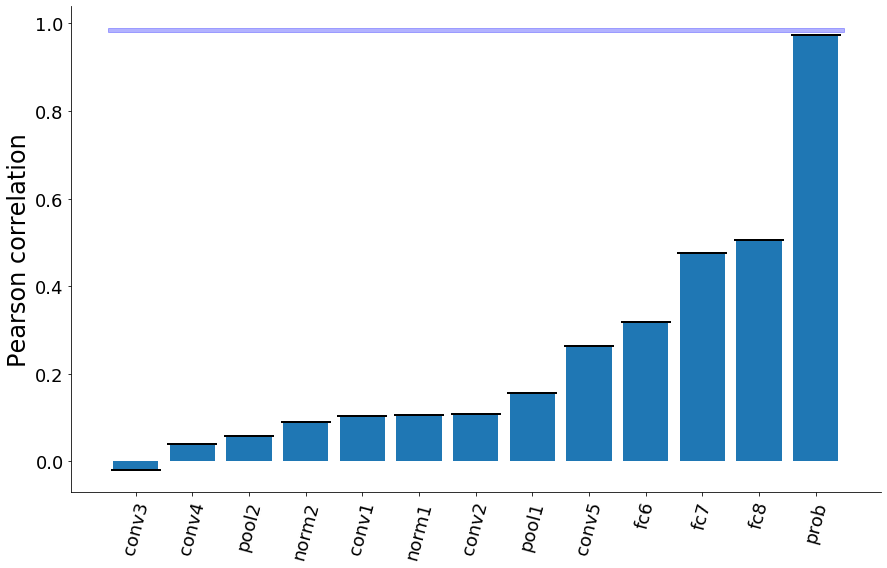

In [12]:
# As we are now using flexible models, we have to do crossvalidation to get an estimate
# how well the model would do on new unseen data
# generate crossvalidation sets:
train_set, test_set, ceil_set = pyrsa.inference.sets_k_fold(rdms_data, k_pattern=3, k_rdm=2)
# perform crossvalidation
results_3_cv = pyrsa.inference.crossval(models_flex, rdms_data, train_set, test_set, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_cv)

In [ ]:
# To perform bootstrapping around this we can run:
results_3_full = pyrsa.inference.bootstrap_crossval(models, rdms_data, k_pattern=3, k_rdm=2, method='corr')
# plot results
pyrsa.vis.plot_model_comparison(results_3_full)

 17%|█▋        | 174/1000 [00:06<00:30, 27.19it/s]